In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm
import torch.nn.functional as F
import random

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# --- Configuration ---
KAGGLE_DATA_ROOT = '/kaggle/input/face-recognition5'
TRAIN_DIR = os.path.join(KAGGLE_DATA_ROOT, 'classification_data', 'train_data')
VERIF_PAIRS_VAL = os.path.join(KAGGLE_DATA_ROOT, 'verification_pairs_val.txt')
MODEL_SAVE_PATH = '/kaggle/working/metric_learning_model.pth'

# --- Hyperparameters ---
IMAGE_SIZE = (224, 224) # ResNet expects 224x224
BATCH_SIZE = 32         # Batches of triplets
LEARNING_RATE = 0.0001  # Metric learning often needs a lower LR
NUM_EPOCHS = 15         # May need more
EMBEDDING_DIM = 512     # Our desired embedding size
MARGIN = 1.0            # The 'margin' for the triplet loss

In [3]:
class TripletFaceDataset(Dataset):
    """
    Custom Dataset for serving triplets.
    On a 'get' call, it returns (anchor_img, positive_img, negative_img)
    """
    def __init__(self, root_dir, transform=None, subset_fraction=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_paths = {} # Map: class_name -> [list of image paths]
        self.class_list = []     # List of all class names

        print("Indexing dataset... this may take a moment.")
        # Pre-process the directory to map classes to image paths
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            self.class_list.append(class_name)
            self.class_to_paths[class_name] = []
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.class_to_paths[class_name].append(img_path)
        
        # Create a flat list of all image paths and their labels
        full_anchor_list = [] # (image_path, class_name)
        for class_name, paths in self.class_to_paths.items():
            for path in paths:
                full_anchor_list.append((path, class_name))
                
        print(f"Dataset: Found {len(self.class_list)} classes and {len(full_anchor_list)} total images.")

        # --- THIS IS THE NEW PART ---
        # Instead of using all images, take a random subset
        if subset_fraction < 1.0:
            num_to_sample = int(len(full_anchor_list) * subset_fraction)
            # Sample without replacement
            indices = np.random.choice(len(full_anchor_list), num_to_sample, replace=False)
            self.anchor_list = [full_anchor_list[i] for i in indices]
            print(f"Using a subset of {num_to_sample} images ({subset_fraction * 100:.0f}%) for training.")
        else:
            self.anchor_list = full_anchor_list
            print(f"Using all {len(self.anchor_list)} images for training.")
        # --- END OF NEW PART ---


    def __len__(self):
        return len(self.anchor_list)

    def __getitem__(self, index):
        # 1. Get Anchor
        anchor_path, anchor_class = self.anchor_list[index]
        
        # 2. Get Positive (another image of the same class)
        positive_list = self.class_to_paths[anchor_class]
        positive_path = anchor_path
        # Ensure we don't pick the *exact* same image file
        while positive_path == anchor_path and len(positive_list) > 1:
            positive_path = random.choice(positive_list)
        
        # 3. Get Negative (an image from a different class)
        negative_class = random.choice(self.class_list)
        while negative_class == anchor_class:
            negative_class = random.choice(self.class_list)
            
        negative_list = self.class_to_paths[negative_class]
        negative_path = random.choice(negative_list)
        
        # 4. Load and transform images
        anchor_img = self.load_image(anchor_path)
        positive_img = self.load_image(positive_path)
        negative_img = self.load_image(negative_path)
        
        return anchor_img, positive_img, negative_img

    def load_image(self, path):
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [4]:
# --- HYPERPARAMETERS ---
SUBSET_FRACTION = 0.2   # Use 20% of the data. Adjust this as needed.
BATCH_SIZE = 64         # Try a larger batch size
NUM_WORKERS = 2         # 2 is safe for Kaggle, can try 4
PIN_MEMORY = True       # Helps speed up data transfer to GPU

# Define transformations (same as before)
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    # Instantiate the Triplet Dataset WITH THE SUBSET
    train_dataset = TripletFaceDataset(
        root_dir=TRAIN_DIR,
        transform=train_transform,
        subset_fraction=SUBSET_FRACTION  # <-- This is the key
    )
    
    # Create the DataLoader with new settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY # <-- New
    )
    
    # Test one batch
    anchor, positive, negative = next(iter(train_loader))
    print(f"\nBatch shapes:")
    print(f"Anchor:   {anchor.shape}")
    print(f"Positive: {positive.shape}")
    print(f"Negative: {negative.shape}")

except Exception as e:
    print(f"Error loading data: {e}")

Indexing dataset... this may take a moment.
Dataset: Found 4000 classes and 380638 total images.
Using a subset of 76127 images (20%) for training.

Batch shapes:
Anchor:   torch.Size([64, 3, 224, 224])
Positive: torch.Size([64, 3, 224, 224])
Negative: torch.Size([64, 3, 224, 224])


In [5]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=512):
        super(EmbeddingNet, self).__init__()
        
        # Load a pre-trained ResNet-18
        self.model = models.resnet18(pretrained=True)
        
        # Get the number of input features for the final layer
        num_ftrs = self.model.fc.in_features
        
        # Replace the final layer with our embedding layer
        # This new layer will output the 512-dim embedding
        self.model.fc = nn.Linear(num_ftrs, embedding_dim)
        
        # Optional: Add L2 normalization (common in metric learning)
        self.l2_norm = nn.functional.normalize

    def forward(self, x):
        x = self.model(x)
        x = self.l2_norm(x, p=2, dim=1) # Normalize embeddings
        return x

model = EmbeddingNet(embedding_dim=EMBEDDING_DIM).to(device)
print("Embedding model created.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


Embedding model created.


In [6]:
# --- Set up Loss and Optimizer ---
# This is the key: TripletMarginLoss
criterion = nn.TripletMarginLoss(margin=MARGIN)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Function ---
def train_triplet_model(model, loader, criterion, optimizer, num_epochs):
    print("Starting training...")
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        running_loss = 0.0
        
        # Use tqdm for a progress bar
        batch_iterator = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for anchor, positive, negative in batch_iterator:
            # Move data to GPU
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass: get embeddings
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            
            # Calculate the triplet loss
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            
            # Backward pass + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            batch_iterator.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print('Training complete!')
    return model

# --- Run Training ---
if 'train_loader' in locals():
    model = train_triplet_model(model, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)
    
    # Save the model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
else:
    print("Skipping training, data loader not found.")

Starting training...


Epoch 1/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 1/15, Loss: 0.3912


Epoch 2/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 2/15, Loss: 0.3260


Epoch 3/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 3/15, Loss: 0.3039


Epoch 4/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 4/15, Loss: 0.2933


Epoch 5/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 5/15, Loss: 0.2838


Epoch 6/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 6/15, Loss: 0.2768


Epoch 7/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 7/15, Loss: 0.2683


Epoch 8/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 8/15, Loss: 0.2622


Epoch 9/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 9/15, Loss: 0.2575


Epoch 10/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 10/15, Loss: 0.2543


Epoch 11/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 11/15, Loss: 0.2492


Epoch 12/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 12/15, Loss: 0.2437


Epoch 13/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 13/15, Loss: 0.2386


Epoch 14/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 14/15, Loss: 0.2365


Epoch 15/15:   0%|          | 0/1190 [00:00<?, ?it/s]

Epoch 15/15, Loss: 0.2323
Training complete!
Model saved to /kaggle/working/metric_learning_model.pth


In [11]:
# 1. Load the model structure
embedding_model = EmbeddingNet(embedding_dim=EMBEDDING_DIM)

# 2. Load the saved weights
try:
    embedding_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    embedding_model = embedding_model.to(device)
    embedding_model.eval() # Set to evaluation mode
    print("Trained metric learning weights loaded successfully.")
    
    # Test with a dummy input
    dummy_input = torch.randn(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)
    output = embedding_model(dummy_input)
    print(f"Embedding vector shape: {output.shape}") # Should be [1, 512]
    
except FileNotFoundError:
    print(f"ERROR: Model file not found at {MODEL_SAVE_PATH}. Did the training step run?")
except Exception as e:
    print(f"An error occurred: {e}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trained metric learning weights loaded successfully.
Embedding vector shape: torch.Size([1, 512])


In [13]:
# We need a transform for single images
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_embedding(image_path, model, transform):
    """
    Given an image path, load it, transform it,
    and return its embedding vector.
    """
    try:
        # 1. Load image
        img = Image.open(image_path).convert('RGB')
        # 2. Apply transform
        img_t = transform(img)
        # 3. Add batch dimension (C, H, W) -> (1, C, H, W)
        batch_t = torch.unsqueeze(img_t, 0).to(device)
        
        # 4. Get embedding
        with torch.no_grad(): # No need to track gradients
            embedding = model(batch_t)
        
        # 5. Flatten/convert embedding
        embedding_flat = embedding.cpu().numpy().flatten()
        return embedding_flat
        
    except FileNotFoundError:
        print(f"Warning: File not found {image_path}. Skipping.")
        return None

In [15]:
print("Loading verification pairs...")
try:
    pairs_df = pd.read_csv(VERIF_PAIRS_VAL, sep=' ', header=None, names=['img1', 'img2', 'label'])
    
    # IMPORTANT: Prepend the root directory to image paths
    pairs_df['img1'] = KAGGLE_DATA_ROOT + '/' + pairs_df['img1']
    pairs_df['img2'] = KAGGLE_DATA_ROOT + '/' + pairs_df['img2']
    
    print(f"Loaded {len(pairs_df)} verification pairs.")

    print("\nGenerating embeddings for all pairs (using Metric Learning model)...")
    embeddings1 = []
    embeddings2 = []
    valid_labels = [] # To store labels for pairs where both images were found
    
    for index, row in tqdm(pairs_df.iterrows(), total=pairs_df.shape[0]):
        emb1 = get_embedding(row['img1'], embedding_model, val_transform)
        emb2 = get_embedding(row['img2'], embedding_model, val_transform)
        
        if emb1 is not None and emb2 is not None:
            embeddings1.append(emb1)
            embeddings2.append(emb2)
            valid_labels.append(row['label'])
    
    embeddings1 = np.array(embeddings1)
    embeddings2 = np.array(embeddings2)
    valid_labels = np.array(valid_labels)
    
    print(f"Generated embeddings for {len(valid_labels)} valid pairs.")
    
except FileNotFoundError:
    print(f"Error: Could not find {VERIF_PAIRS_VAL}. Check path.")
except Exception as e:
    print(f"An error occurred: {e}")

Loading verification pairs...
Loaded 8805 verification pairs.

Generating embeddings for all pairs (using Metric Learning model)...


  0%|          | 0/8805 [00:00<?, ?it/s]

Generated embeddings for 8805 valid pairs.



--- Evaluation Results (Metric Learning) ---
AUC (Cosine Similarity): 0.8855
AUC (Euclidean Distance): 0.8855


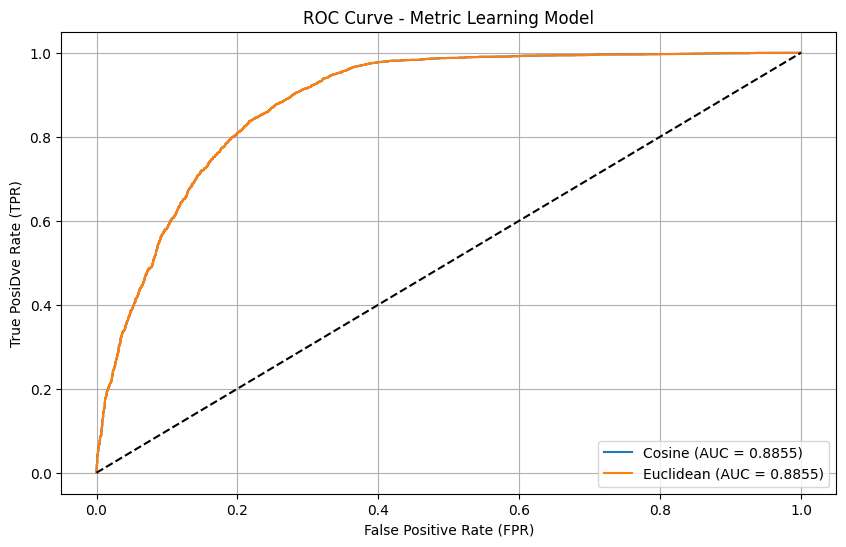

In [16]:
if 'embeddings1' in locals() and len(embeddings1) > 0:
    # --- 1. Calculate Cosine Similarity ---
    emb1_t = torch.from_numpy(embeddings1)
    emb2_t = torch.from_numpy(embeddings2)
    # Note: Our model already L2-normalized the vectors,
    # so cosine similarity is just a dot product.
    # But F.cosine_similarity is safer.
    cosine_scores = F.cosine_similarity(emb1_t, emb2_t).numpy()
    
    # --- 2. Calculate Euclidean Distance ---
    diff = embeddings1 - embeddings2
    euclidean_dist = np.sqrt(np.sum(np.square(diff), axis=1))
    euclidean_scores = -euclidean_dist # Higher score = more similar
    
    # Get true labels
    true_labels = valid_labels
    
    # --- 3. Calculate ROC/AUC for both metrics ---
    fpr_cos, tpr_cos, thresholds_cos = roc_curve(true_labels, cosine_scores)
    auc_cos = auc(fpr_cos, tpr_cos)
    
    fpr_euc, tpr_euc, thresholds_euc = roc_curve(true_labels, euclidean_scores)
    auc_euc = auc(fpr_euc, tpr_euc)
    
    print(f"\n--- Evaluation Results (Metric Learning) ---")
    print(f"AUC (Cosine Similarity): {auc_cos:.4f}")
    print(f"AUC (Euclidean Distance): {auc_euc:.4f}")
    
    # --- 4. Plot ROC Curve ---
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_cos, tpr_cos, label=f'Cosine (AUC = {auc_cos:.4f})')
    plt.plot(fpr_euc, tpr_euc, label=f'Euclidean (AUC = {auc_euc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Random guess line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True PosiDve Rate (TPR)')
    plt.title('ROC Curve - Metric Learning Model')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
else:
    print("Skipping evaluation, embeddings not generated.")